In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import LotkaVolterra
from modules.training import train

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [44]:
def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

problem_number = 4
problem = LotkaVolterra.get_problem(problem_number)
name = f'lv{problem_number}_swish'

L, W = 2, 32
model = FeedForwardNetwork(L, W, output_dim=2, activation=Swish(beta=1))

num_iters = 10000
plot_every = 250

coef = 0.8

train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {'lr': 1e-3},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 20000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {'N_F': 4096},
            'generation_function': f
        },
        'coefs': [[coef], [1 - coef, 1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 3)
    },
    name=name,
    print_every=1000
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/lv/{name}_test.gif'
)

Iter ____0 	 77.07694329004906
Iter _1000 	 11.081649670918022
Iter _2000 	 10.787610073972647
Iter _3000 	 10.715421652415387
Iter _4000 	 10.669377086386318
Iter _5000 	 10.628349814240899
Iter _6000 	 10.588623947691273
Iter _7000 	 10.55241164025966
Iter _8000 	 10.496364810409647
Iter _9000 	 10.48842971269206
Creating gif...


In [41]:
clear_temp()

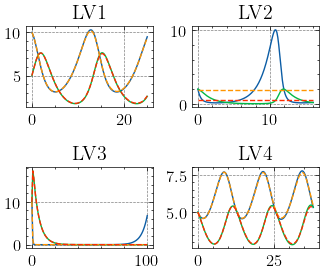

In [60]:
problems = [LotkaVolterra.get_problem(i) for i in range(1, 5)]

size = (3.5, 3)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.t, problem.solution[0])
    axs[i, j].plot(problem.t, problem.solution[1])
    
    test_model = torch.load(f'./studies/lv_{ind + 1}_best_model.pt', map_location='cpu')

    preds = test_model(problem.t.reshape(-1, 1)).detach().numpy()
    x = preds[:,0].flatten()
    y = preds[:,1].flatten()
    
    axs[i, j].plot(problem.t, x, linestyle='dashed')
    axs[i, j].plot(problem.t, y, linestyle='dashed')
    
    axs[i, j].title.set_text(f'LV{ind+1}')
    
plt.tight_layout()

plt.savefig('../images/lv_solutions_grid.png', dpi=250)
plt.show()